In [65]:
# Imports and environment info
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
# Print versions
print('python', sys.version.split()[0])
print('pandas', pd.__version__)
print('numpy', np.__version__)
import sklearn
print('scikit-learn', sklearn.__version__)
print('matplotlib', plt.matplotlib.__version__)
print('seaborn', sns.__version__)

python 3.13.3
pandas 2.2.3
numpy 2.3.4
scikit-learn 1.7.0
matplotlib 3.10.3
seaborn 0.13.2


In [66]:
# Load dataset 
df = pd.read_csv("StudentsPerformance.csv")
print('shape:', df.shape)
df.head()

shape: (1000, 8)


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [67]:
# Quick inspection
df.info()
display(df.describe())
# value counts for categorical columns
for c in ['gender','race/ethnicity','parental level of education','lunch','test preparation course']:
    print('\n', c)
    print(df[c].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000



 gender
gender
female    518
male      482
Name: count, dtype: int64

 race/ethnicity
race/ethnicity
group C    319
group D    262
group B    190
group E    140
group A     89
Name: count, dtype: int64

 parental level of education
parental level of education
some college          226
associate's degree    222
high school           196
some high school      179
bachelor's degree     118
master's degree        59
Name: count, dtype: int64

 lunch
lunch
standard        645
free/reduced    355
Name: count, dtype: int64

 test preparation course
test preparation course
none         642
completed    358
Name: count, dtype: int64


In [68]:
# Data cleaning checks
# Ensure score columns numeric
score_cols = ['math score','reading score','writing score']
for col in score_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
print('Missing values by column:')
print(df.isnull().sum())
# If any missing in scores, show rows
print(df[df[score_cols].isnull().any(axis=1)])

Missing values by column:
gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64
Empty DataFrame
Columns: [gender, race/ethnicity, parental level of education, lunch, test preparation course, math score, reading score, writing score]
Index: []


In [69]:
# Feature encoding

cat_cols = ['gender','race/ethnicity','parental level of education','lunch','test preparation course']
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)
print('encoded shape:', df_encoded.shape)
df_encoded.head()

encoded shape: (1000, 15)


,math score,reading score,writing score,gender_male,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E,parental level of education_bachelor's degree,parental level of education_high school,parental level of education_master's degree,parental level of education_some college,parental level of education_some high school,lunch_standard,test preparation course_none
0,72,72,74,False,True,False,False,False,True,False,False,False,False,True,True
1,69,90,88,False,False,True,False,False,False,False,False,True,False,True,False
2,90,95,93,False,True,False,False,False,False,False,True,False,False,True,True
3,47,57,44,True,False,False,False,False,False,False,False,False,False,False,True
4,76,78,75,True,False,True,False,False,False,False,False,True,False,True,True


In [70]:
# Prepare features and targets
X = df_encoded.drop(['math score','reading score','writing score'], axis=1)
y_math = df_encoded['math score']
y_reading = df_encoded['reading score']
y_writing = df_encoded['writing score']
print('X shape', X.shape)

X shape (1000, 12)


In [71]:
# Modeling helpers
def train_and_evaluate(X, y, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    results = {}
    # Linear Regression pipeline
    pipe_lr = Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())])
    pipe_lr.fit(X_train, y_train)
    y_pred_lr = pipe_lr.predict(X_test)
    rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
    results['LinearRegression'] = {'rmse': rmse_lr, 'r2': r2_score(y_test, y_pred_lr), 'model': pipe_lr, 'y_test': y_test, 'y_pred': y_pred_lr}
    return results

In [72]:
# Train and evaluate for each target
summary = []
for name, y in [('math', y_math), ('reading', y_reading), ('writing', y_writing)]:
    res = train_and_evaluate(X, y)
    summary.extend(
        {
            'target': name,
            'model': model_name,
            'rmse': stats['rmse'],
            'r2': stats['r2'],
        }
        for model_name, stats in res.items()
    )
summary_df = pd.DataFrame(summary)
display(summary_df.sort_values(['target','rmse']))

,target,model,rmse,r2
0,math,LinearRegression,14.160185,0.176000
1,reading,LinearRegression,13.791864,0.159396
2,writing,LinearRegression,13.321117,0.263736


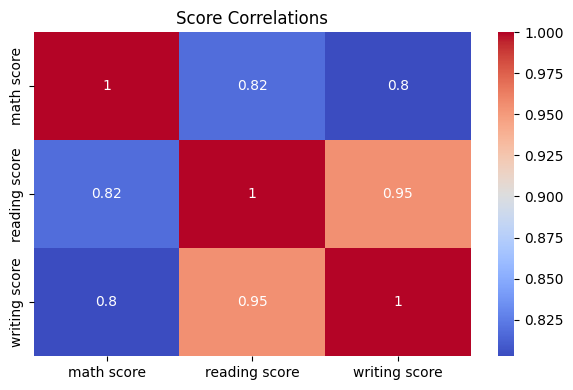

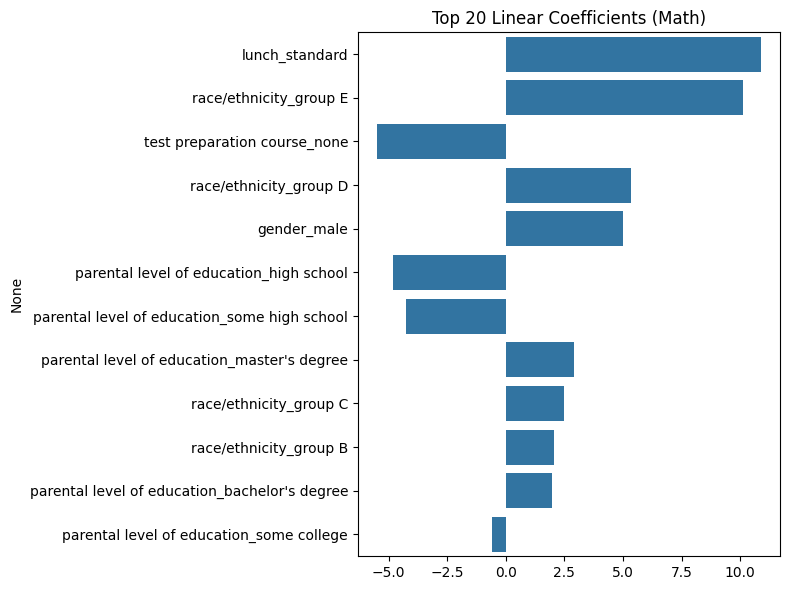

Top 5 coefficients (math):
lunch_standard                  10.876832
race/ethnicity_group E          10.134735
test preparation course_none    -5.494671
race/ethnicity_group D           5.341035
gender_male                      4.995298
dtype: float64

Top 5 coefficients (reading):
test preparation course_none              -7.362454
lunch_standard                             7.245802
gender_male                               -7.071392
race/ethnicity_group E                     5.513513
parental level of education_high school   -4.900416
dtype: float64

Top 5 coefficients (writing):
test preparation course_none              -10.058719
gender_male                                -9.096461
lunch_standard                              8.202754
race/ethnicity_group D                      5.930691
parental level of education_high school    -5.814340
dtype: float64


In [73]:
# Plots - correlation and linear regression coefficients
plt.figure(figsize=(6,4))
sns.heatmap(df[['math score','reading score','writing score']].corr(), annot=True, cmap='coolwarm')
plt.title('Score Correlations')
plt.tight_layout()
plt.show()

# Linear regression coefficients for math
lr = LinearRegression()
lr.fit(X, y_math)
coefs_math = pd.Series(lr.coef_, index=X.columns).sort_values(key=abs, ascending=False).head(20)
plt.figure(figsize=(8,6))
sns.barplot(x=coefs_math.values, y=coefs_math.index)
plt.title('Top 20 Linear Coefficients (Math)')
plt.tight_layout()
plt.show()

# Compare coefficients across targets
lr.fit(X, y_math)
coefs_math = pd.Series(lr.coef_, index=X.columns).sort_values(key=abs, ascending=False)
lr.fit(X, y_reading)
coefs_reading = pd.Series(lr.coef_, index=X.columns).sort_values(key=abs, ascending=False)
lr.fit(X, y_writing)
coefs_writing = pd.Series(lr.coef_, index=X.columns).sort_values(key=abs, ascending=False)

# Display top 5 for each target
print('Top 5 coefficients (math):')
print(coefs_math.head(5))
print('\nTop 5 coefficients (reading):')
print(coefs_reading.head(5))
print('\nTop 5 coefficients (writing):')
print(coefs_writing.head(5))

In [76]:
# Save artifacts and requirements
out_dir = Path.cwd() / 'artifacts'
out_dir.mkdir(exist_ok=True)

# Save the Linear Regression model for math as an example
lr = LinearRegression()
lr.fit(X, y_math)
joblib.dump(lr, out_dir / 'lr_math.joblib')

# Write requirements.txt
reqs = ['pandas','numpy','scikit-learn','matplotlib','seaborn','joblib']
with open('requirements.txt','w') as f:
    f.write('\n'.join(reqs))

print('Artifacts and requirements saved to', out_dir, 'and requirements.txt')

Artifacts and requirements saved to c:\Users\kayce\OneDrive\Documents\Student-performance\data\artifacts and requirements.txt
